In [1]:
import numpy as np
import pandas as pd
import reviewmethods2 as r2
reviews = pd.read_parquet(path="reviews_equal_processed_prediction_3.parquet", use_nullable_dtypes=True, engine='pyarrow')
reviews = reviews.sample(frac=1, random_state=42).reset_index(drop=True)
reviews.dropna(inplace=True)
reviews.info()
dataset_size = [10_000, 30_000, 50_000, 100_000, 300_000, 500_000]


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/oskar/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to /home/oskar/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 8 columns):
 #   Column                               Non-Null Count   Dtype   
---  ------                               --------------   -----   
 0   review                               500000 non-null  string  
 1   appid                                500000 non-null  Int64   
 2   review_type                          500000 non-null  category
 3   review_type_encoded                  500000 non-null  Int64   
 4   logistic_500_000_prediction          500000 non-null  Int64   
 5   logistic_500_000_prediction_correct  500000 non-null  boolean 
 6   LSTM_500_000_prediction              500000 non-null  Int64   
 7   LSTM_500_000_prediction_correct      500000 non-null  boolean 
dtypes: Int64(4), boolean(2), category(1), string(1)
memory usage: 23.4 MB


In [2]:
reviews['review_type'].value_counts()


negative    250000
positive    250000
Name: review_type, dtype: int64

In [3]:
import time
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

train_ratio = 0.7
dev_ratio = 0.15
test_ratio = 0.15
target_names = ['negative', 'positive']
reports = []
class_precision = []
class_recall = []
class_fscore = []
class_support = []
Name = []
Accuracy_dev = []
Precision_dev = []
F1_Score_dev = []
Recall_dev = []
Time_Taken_dev = []
Accuracy_test = []
Precision_test = []
F1_Score_test = []
Recall_test = []
Time_Taken_test = []
for amount in dataset_size:
    tfid = TfidfVectorizer(stop_words='english', ngram_range=(1, 2))
    X = tfid.fit_transform(reviews['review'].head(amount))
    y = LabelEncoder().fit_transform(reviews['review_type'].head(amount))
    print(reviews['review_type'].head(amount).value_counts())
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1 - train_ratio, random_state=42, stratify=y,
                                                        shuffle=True)
    X_dev, X_test, y_dev, y_test = train_test_split(X_test, y_test, test_size=test_ratio / (test_ratio + dev_ratio),
                                                    random_state=42)

    name = 'LogisticRegression n='+str(amount)
    Name.append(name)
    begin = time.time()
    model = LogisticRegression(random_state=42, n_jobs=-1, max_iter=10_000)
    model.fit(X_train, y_train)
    prediction = model.predict(X_dev)
    end = time.time()
    Accuracy_dev.append(accuracy_score(prediction, y_dev))
    Precision_dev.append(precision_score(prediction, y_dev, average='macro'))
    Recall_dev.append(recall_score(prediction, y_dev, average='macro'))
    F1_Score_dev.append(f1_score(prediction, y_dev, average='macro'))
    Time_Taken_dev.append(end - begin)
    print(name + ' Successfully Trained')
    begin = time.time()
    prediction_test = model.predict(X_test)
    end = time.time()
    reports.append(classification_report(
        y_test, prediction_test, target_names=target_names))
    precision, recall, fscore, support = precision_recall_fscore_support(
        y_test, prediction_test)
    class_precision.append(precision)
    class_recall.append(recall)
    class_fscore.append(fscore)
    class_support.append(support)
    Accuracy_test.append(accuracy_score(prediction_test, y_test))
    Precision_test.append(precision_score(
        prediction_test, y_test, average='macro'))
    Recall_test.append(recall_score(prediction_test, y_test, average='macro'))
    F1_Score_test.append(f1_score(prediction_test, y_test, average='macro'))
    Time_Taken_test.append(end - begin)
Dict_dev_unbalance = {'Name': Name, 'n': dataset_size, 'Accuracy_dev': Accuracy_dev, 'Precision_score_dev': Precision_dev, 'Recall_score_dev': Recall_dev,
                      'F1_score_dev': F1_Score_dev, 'Time Taken_dev': Time_Taken_dev}
Dict_test_unbalance = {'Name': Name, 'n': dataset_size, 'Accuracy_test': Accuracy_test, 'Precision_score_test': Precision_test, 'Recall_score_test': Recall_test,
                       'F1_score_test': F1_Score_test, 'Time Taken_test': Time_Taken_test}
model_df_dev_unbalance = pd.DataFrame(Dict_dev_unbalance)
# model_df_dev
model_df_test_unbalance = pd.DataFrame(Dict_test_unbalance)
model_df_test_unbalance


negative    5048
positive    4952
Name: review_type, dtype: int64
LogisticRegression n=10000 Successfully Trained
negative    15021
positive    14979
Name: review_type, dtype: int64
LogisticRegression n=30000 Successfully Trained
positive    25031
negative    24969
Name: review_type, dtype: int64
LogisticRegression n=50000 Successfully Trained
negative    50070
positive    49930
Name: review_type, dtype: int64
LogisticRegression n=100000 Successfully Trained
positive    150095
negative    149905
Name: review_type, dtype: int64
LogisticRegression n=300000 Successfully Trained
negative    250000
positive    250000
Name: review_type, dtype: int64


: 

: 

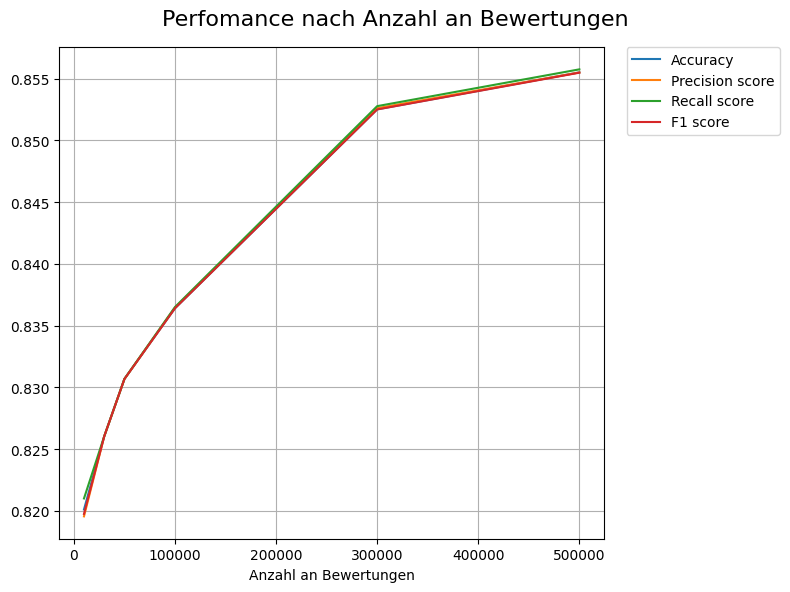

In [ ]:
plt.rcParams["figure.figsize"] = 8, 6
fig, (ax, lax) = plt.subplots(ncols=2, gridspec_kw={"width_ratios": [9, 1]})
ax.plot(dataset_size, Accuracy_test, label="Accuracy")
ax.plot(dataset_size, Precision_test, label="Precision score")
ax.plot(dataset_size, Recall_test, label="Recall score")
ax.plot(dataset_size, F1_Score_test, label="F1 score")
ax.grid(True)
h, l = ax.get_legend_handles_labels()
lax.legend(h, l, borderaxespad=0)
lax.axis("off")
fig.suptitle('Perfomance nach Anzahl an Bewertungen', fontsize=16)
ax.set_xlabel('Anzahl an Bewertungen')
plt.tight_layout()


In [ ]:
for report in reports:
    print(report)


              precision    recall  f1-score   support

    negative       0.81      0.85      0.83       765
    positive       0.83      0.79      0.81       736

    accuracy                           0.82      1501
   macro avg       0.82      0.82      0.82      1501
weighted avg       0.82      0.82      0.82      1501

              precision    recall  f1-score   support

    negative       0.83      0.83      0.83      2255
    positive       0.83      0.83      0.83      2246

    accuracy                           0.83      4501
   macro avg       0.83      0.83      0.83      4501
weighted avg       0.83      0.83      0.83      4501

              precision    recall  f1-score   support

    negative       0.83      0.83      0.83      3736
    positive       0.83      0.83      0.83      3765

    accuracy                           0.83      7501
   macro avg       0.83      0.83      0.83      7501
weighted avg       0.83      0.83      0.83      7501

              preci

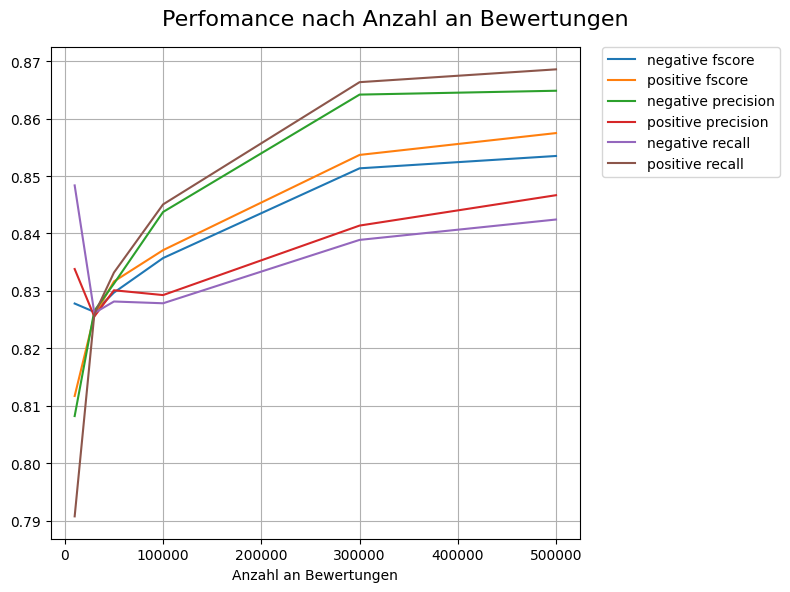

In [ ]:
negative_fscore, positive_fscore = zip(*class_fscore)
negative_precision, positive_precision = zip(*class_precision)
negative_recall, positive_recall = zip(*class_recall)
negative_support, positive_support = zip(*class_support)
plt.rcParams["figure.figsize"] = 8, 6
fig, (ax, lax) = plt.subplots(ncols=2, gridspec_kw={"width_ratios": [8, 1]})
ax.plot(dataset_size, negative_fscore, label="negative fscore")
ax.plot(dataset_size, positive_fscore, label="positive fscore")
ax.plot(dataset_size, negative_precision, label="negative precision")
ax.plot(dataset_size, positive_precision, label="positive precision")
ax.plot(dataset_size, negative_recall, label="negative recall")
ax.plot(dataset_size, positive_recall, label="positive recall")
ax.grid(True)
h, l = ax.get_legend_handles_labels()
lax.legend(h, l, borderaxespad=0)
lax.axis("off")
fig.suptitle('Perfomance nach Anzahl an Bewertungen', fontsize=16)
ax.set_xlabel('Anzahl an Bewertungen')
plt.tight_layout()


In [ ]:
# tfid = TfidfVectorizer(stop_words='english', ngram_range=(1, 2))
# X = tfid.fit_transform(reviews['review'].head(500_000))
# reviews['review_type_encoded'] = LabelEncoder().fit_transform(
#     reviews['review_type'].head(500_000))
# reviews['logistic_500_000_prediction'] = model.predict(X)
# reviews['logistic_500_000_prediction'] = reviews['logistic_500_000_prediction'].astype(
#     'category')
# reviews['logistic_500_000_prediction_correct'] = np.where((reviews['logistic_500_000_prediction'] == reviews['review_type_encoded']), bool(1),bool(0))
reviews['logistic_500_000_prediction_correct'].value_counts(normalize=True)


KeyError: 'logistic_500_000_prediction_correct'

In [ ]:
# import matplotlib.pyplot as plt
# from sklearn.datasets import load_iris
# from sklearn.model_selection import LearningCurveDisplay, learning_curve
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.tree import DecisionTreeClassifier

# X = tfid.fit_transform(reviews['review'])
# y = LabelEncoder().fit_transform(reviews['review_type'])
# tree = LogisticRegression(random_state=42, n_jobs=-1, max_iter=10_000)
# train_sizes, train_scores, test_scores = learning_curve(
#     tree, X, y, n_jobs=1, verbose=1, shuffle=True, random_state=42)
# display = LearningCurveDisplay(train_sizes=train_sizes,
#                                train_scores=train_scores, test_scores=test_scores, score_name="Score")
# display.plot()

# plt.show()


In [ ]:
# reviews.to_parquet(
#     'reviews_equal_processed_prediction.parquet', engine='pyarrow')


### Unbalanced

In [ ]:
reviews = pd.read_parquet(path="reviews2.5_processed.parquet", use_nullable_dtypes=True, engine='pyarrow',
                          columns=['review', 'appid', 'review_type'])
reviews = reviews.sample(frac=1, random_state=42).reset_index(drop=True)
reviews = reviews.head(500_000)
reviews.dropna(inplace=True)
reviews.info()


In [ ]:
import time
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

train_ratio = 0.7
dev_ratio = 0.15
test_ratio = 0.15
target_names = ['negative', 'positive']
reports_unbalance = []
class_precision = []
class_recall = []
class_fscore = []
class_support = []
Name = []
Accuracy_dev = []
Precision_dev = []
F1_Score_dev = []
Recall_dev = []
Time_Taken_dev = []
Accuracy_test = []
Precision_test = []
F1_Score_test = []
Recall_test = []
Time_Taken_test = []
for amount in dataset_size:
    tfid = TfidfVectorizer(stop_words='english', ngram_range=(1, 2))
    X = tfid.fit_transform(reviews['review'].head(amount))
    y = LabelEncoder().fit_transform(reviews['review_type'].head(amount))
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1 - train_ratio, random_state=42, stratify=y,
                                                        shuffle=True)
    X_dev, X_test, y_dev, y_test = train_test_split(X_test, y_test, test_size=test_ratio / (test_ratio + dev_ratio),
                                                    random_state=42)

    name = 'LogisticRegression n='+str(amount)
    Name.append(name)
    begin = time.time()
    model = LogisticRegression(random_state=42, n_jobs=-1, max_iter=10_000)
    model.fit(X_train, y_train)
    prediction = model.predict(X_dev)
    end = time.time()
    Accuracy_dev.append(accuracy_score(prediction, y_dev))
    Precision_dev.append(precision_score(prediction, y_dev, average='macro'))
    Recall_dev.append(recall_score(prediction, y_dev, average='macro'))
    F1_Score_dev.append(f1_score(prediction, y_dev, average='macro'))
    Time_Taken_dev.append(end - begin)
    print(name + ' Successfully Trained')
    begin = time.time()
    prediction_test = model.predict(X_test)
    end = time.time()
    reports_unbalance.append(classification_report(
        y_test, prediction_test, target_names=target_names))
    precision, recall, fscore, support = precision_recall_fscore_support(
        y_test, prediction_test)
    class_precision.append(precision)
    class_recall.append(recall)
    class_fscore.append(fscore)
    class_support.append(support)
    Accuracy_test.append(accuracy_score(prediction_test, y_test))
    Precision_test.append(precision_score(
        prediction_test, y_test, average='macro'))
    Recall_test.append(recall_score(prediction_test, y_test, average='macro'))
    F1_Score_test.append(f1_score(prediction_test, y_test, average='macro'))
    Time_Taken_test.append(end - begin)
Dict_dev = {'Name': Name, 'n': dataset_size, 'Accuracy_dev': Accuracy_dev, 'Precision_score_dev': Precision_dev, 'Recall_score_dev': Recall_dev,
            'F1_score_dev': F1_Score_dev, 'Time Taken_dev': Time_Taken_dev}
Dict_test = {'Name': Name, 'n': dataset_size, 'Accuracy_test': Accuracy_test, 'Precision_score_test': Precision_test, 'Recall_score_test': Recall_test,
             'F1_score_test': F1_Score_test, 'Time Taken_test': Time_Taken_test}
model_df_dev = pd.DataFrame(Dict_dev)
# model_df_dev
model_df_test = pd.DataFrame(Dict_test)
model_df_test


In [ ]:
plt.rcParams["figure.figsize"] = 8, 6
fig, (ax, lax) = plt.subplots(ncols=2, gridspec_kw={"width_ratios": [9, 1]})
ax.plot(dataset_size, Accuracy_test, label="Accuracy")
ax.plot(dataset_size, Precision_test, label="Precision score")
ax.plot(dataset_size, Recall_test, label="Recall score")
ax.plot(dataset_size, F1_Score_test, label="F1 score")
ax.grid(True)
h, l = ax.get_legend_handles_labels()
lax.legend(h, l, borderaxespad=0)
lax.axis("off")
fig.suptitle('Perfomance nach Anzahl an Bewertungen', fontsize=16)
ax.set_xlabel('Anzahl an Bewertungen')
plt.tight_layout()


In [ ]:
for report in reports_unbalance:
    print(report)

In [ ]:
negative_fscore, positive_fscore = zip(*class_fscore)
negative_precision, positive_precision = zip(*class_precision)
negative_recall, positive_recall = zip(*class_recall)
negative_support, positive_support = zip(*class_support)
plt.rcParams["figure.figsize"] = 8, 6
fig, (ax, lax) = plt.subplots(ncols=2, gridspec_kw={"width_ratios": [9, 1]})
ax.plot(dataset_size, negative_fscore, label="negative fscore")
ax.plot(dataset_size, positive_fscore, label="positive fscore")
ax.plot(dataset_size, negative_precision, label="negative precision")
ax.plot(dataset_size, positive_precision, label="positive precision")
ax.plot(dataset_size, negative_recall, label="negative recall")
ax.plot(dataset_size, positive_recall, label="positive recall")
ax.grid(True)
h, l = ax.get_legend_handles_labels()
lax.legend(h, l, borderaxespad=0)
lax.axis("off")
fig.suptitle('Perfomance nach Anzahl an Bewertungen', fontsize=16)
ax.set_xlabel('Anzahl an Bewertungen')
plt.tight_layout()


In [ ]:
# tfid = TfidfVectorizer(stop_words='english', ngram_range=(1, 2))
# X = tfid.fit_transform(reviews['review'].head(500_000))
# reviews['review_type_encoded'] = LabelEncoder().fit_transform(reviews['review_type'].head(500_000))
# reviews['logistic_500_000_prediction'] = model.predict(X)
# reviews['logistic_500_000_prediction'] = reviews['logistic_500_000_prediction'].astype(
#     'category')
# reviews['logistic_500_000_prediction_correct'] = np.where((reviews['logistic_500_000_prediction'] == reviews['review_type_encoded']), bool(1),
#                                                           bool(0))
# reviews['logistic_500_000_prediction_correct'].value_counts(normalize=True)


In [ ]:
review_sentiment_per_game_log = reviews.groupby(['appid','review_type', 'logistic_500_000_prediction_correct']).logistic_500_000_prediction_correct.count().unstack()
review_sentiment_per_game_log.head(10)

In [ ]:
review_sentiment_per_game_LSTM = reviews.groupby(['appid','review_type', '']).logistic_500_000_prediction_correct.count().unstack()
review_sentiment_per_game_LSTM.head(10)

In [ ]:
# reviews.to_parquet('reviews2.5_processed_prediction.parquet', engine='pyarrow')